# Ensemble Learning and Random Forests

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting Classifiers

**Voting Classifiers** consist of techniques to improve the performance of models, making them perform better together than individually. In general terms, it can be divided into _Hard Voting_ and _Soft Voting_.

**Hard Voting** aggregates the predictions of the models, and the model that has the most votes is the _ensemble's prediction_.


<div class="alert alert-block alert-info">
<b>Note:</b> Even if the models are <i>weak learners</i> (slightly better than random guessing) the ensemble can still be a <i>strong learner</i> (having high accuracy) if there are enough <i>weak learners</i>.
</div>


It is possible to use `VotingClassifier` from Scikit-Learn. When using this class, it **clones the estimators and fits the clones**. It is possible to see the attributes of the estimators via `estimators_`, `named_estimators` or `named_estimators_`.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

The individual performance of the classifiers is:

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [8]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

And the voting performance is:

In [10]:
voting_clf.score(X_test, y_test)

0.912

If the classifiers can estimate the probabilities of the classes (`predict_proba()`) they can predict with greater weight for the most confident voters, performing **Soft Voting**.

In [12]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Pasting

Other strategies other than voting use a different tactic. The same training set is used for all predictors, but it is trained with different random subsets in the training set. **Bagging** and **Pasting** use this strategy with slight differences:

- **Bagging**: When _using_ replacement
- **Pasting**: When _not_using_ replacement

After all the predictors have been trained and made predictions, an ensemble of all the predictors is created, using _Statistical Mode_ for _classifiers_ (similar to hard voting) and a _simple average_ for _regressions_.

The process also reduces the _bias_ and _variance_ of individual predictors.

### Bagging and Pasting in Scikit-Learn

The code below demonstrates an example of Bagging with 500 Decision Tree predictors (`n_estimators`) with 100 training instances (`max_samples`). It is interesting to note that _Soft Voting_ is applied if the BaggingClassifiers classification predictors have the attribute to estimate the probability of the class `predict_proba()`.

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

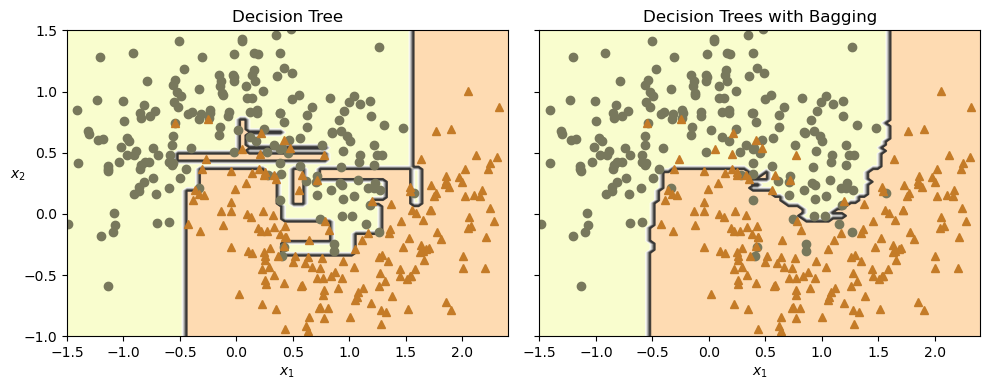

In [18]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out-of-Bag Evaluation

Using Bagging typically results in approximately 63% of the training instances being used, with the other 37% not participating in the training. This 37% portion is called _Out-Of-Bag_ (OOB).

Often, the OOB is used as a validation set and evaluates the accuracy of the model. This can be done from Scikit-Learn using the oob_score_ class. In addition, it is possible to use the decision function for each training instance from `oob_decision_function_`, which can return the class probabilities if there is the `predict_proba()` method.

In [21]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [22]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [23]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

### Random Patches and Random Subspaces

Feature sampling is something that proves useful when dealing with high-dimensional inputs such as images, and is called the Random Patches Method. Two hyperparameters can control this, `max_features` and `bootstrap_features`.

By keeping all training instances (e.g. `bootstrap` = False and `max_samples` = 1.0) except for the sampled features, it is called the Random Subspaces Method. This results in more diverse predictors, having higher bias and lower variance.

## Random Forests

**Random Forest** operates in a way that uses a `Bagging Classifier` on a `DecisionTreeClassifier`, or, more directly, `RandomForestClassifier`.

In [29]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [30]:
y_pred_rf = rnd_clf.predict(X_test)
print(y_pred_rf)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


<div class="alert alert-block alert-info">
<b>Note:</b> The algorithm, instead of using the best feature during splitting, searches for the best feature in a random subset, usually in $\sqrt{n}$. Because of this, a <b>high bias</b> is exchanged for a <b>low variance</b>.
</div>

It is also possible to perform the above task using `Bagging`+ `Decision Tree`

In [33]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators=500, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_features='sqrt',
                                                   max_leaf_nodes=16),
                  n_estimators=500, n_jobs=-1, random_state=42)

In [34]:
y_pred_bag = bag_clf.predict(X_test)
y_pred_bag

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

### Extra-Trees

**Extra Trees** (or Extremely Randomized Trees) is a technique that trades _more bias_ for _less variance_, also speeding up the algorithm. It is possible to use both classification and regression using `ExtraTreesClassifier` or `ExtraTreesRegressor`. The algorithm operates in a similar way to _Random Trees_, with the addition of using **random thresholds**.

<div class="alert alert-block alert-info">
<b>Note:</b> It is difficult to say which will perform better between <b>Random Trees</b> and <b>Extra Trees</b>, but the best way is to compare using <i>Cross-Validation</i>. 
</div>

### Feature Importance

The analyzed features are subjected to a **weighted average**, where the weight of each node is equivalent to the number of training samples associated with it. The code below demonstrates the example, where we see that the respective weights are:

44% - petal length, 42% - petal width, 11% - sepal length and 2% - sepal width

In [39]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


This is also possible by analyzing images, demonstrating which pixels are more or less important:

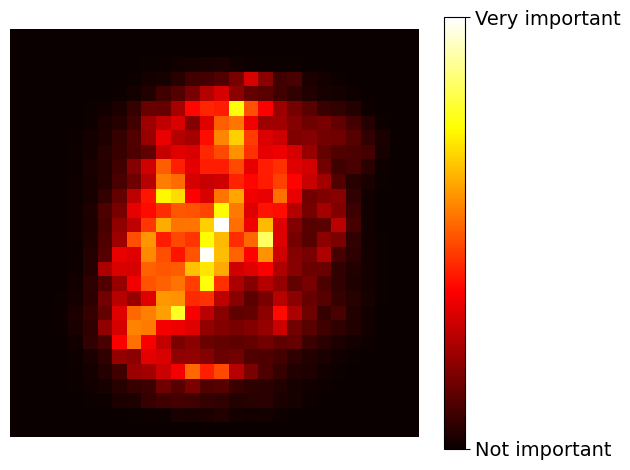

In [41]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting

**Boosting** is an Ensemble method that uses multiple _weak learners_ to compose a _strong learner_. It operates by making predictors in succession with the intention of the successor being better than each predecessor.

### AdaBoost

**AdaBoost** (or _Adaptive Boosting_) operates by focusing on **hard cases**, that is, paying more attention to training instances that have undergone _Underfitting_.

For example, it starts a classification (first prediction), and then increases the weight of the incorrectly classified instances (second prediction), and does this successively.

<div class="alert alert-block alert-warning">
<b>Alert:</b> This type of training occurs <b>in series, not in parallel</b>. Therefore, unlike other Ensemble forms, <b>it does not scale well</b>.
</div>

An example can be seen in the code below:

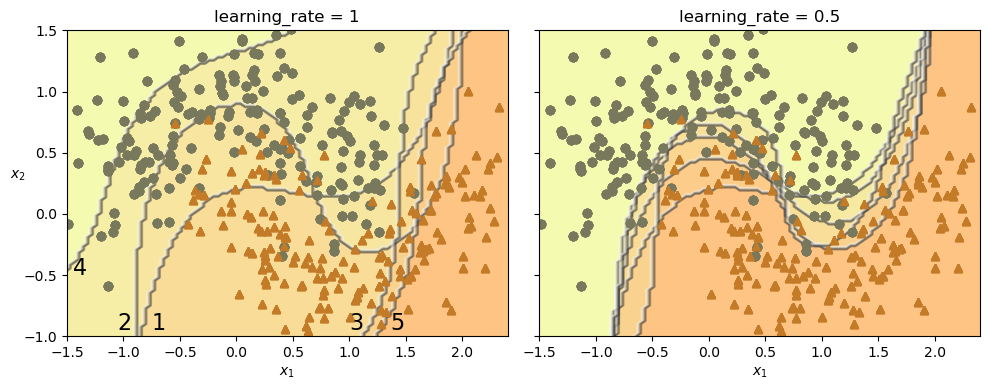

In [47]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

Below, we will explain how the algorithm works step by step, this section is optional.

A brief summary of how the algorithm works is shown below:

1. First prediction
2. Weighted Error Rate
3. Predictor Weight
4. Instance Weight Update Rule
5. AdaBoost Prediction

**1. First Prediction**

In the first prediction, all weights are set to the same value, $w
^{(i)} = \frac{1}{m}$, where m is the number of instances.

**2. Weighted Error Rate**

After the first predictor is trained, an error rate is calculated with the equation, where $\hat{y}_{j}^{(i)}$  is the prediction for the $i^{th}$ term:

$$
r_{j} = \sum_{i=1 \: \: and \: \: \hat{y}_{j}^{(i)} \neq y_{j}^{(i)}}^{m} w^{(i)}
$$

**3. Predictor Weight**

The more accurate the predictor, the greater this weight $\alpha_{j}$ will be. The equation below demonstrates how it is calculated, with $\eta$ being the _Learning Rate_ hyperparameter.
$$
\alpha _{j} = \eta \: log \frac{1 - r_{j}}{r_{j}}
$$

**4. Instance Weight Update Rule**

The update of the instance weights is done by maintaining the weight of the correct predictions and updating the weights of those that were misclassified:

$$
w^{(i)} \leftarrow \left\{  \begin{matrix} 
w^{(i)} \: \: \: if \: \: \: \hat{y}^{(i)}_{j} = y^{(i)} \\
w^{(i)} exp(\alpha_{j}) \: \: \: if \: \: \: \hat{y}^{(i)}_{j} \neq y^{(i)}
\end{matrix} \right.
$$

After this, the weights are normalized.

**5. AdaBoost Prediction**

After the weights are updated, new predictions are made and the cycle repeats. This is done until a defined threshold is reached or a perfect predictor is reached.

The class (k) that receives the highest number of votes will be the chosen predictor, which is demonstrated by the equation below:

$$
\hat{y}(x) = argmax_{k} \sum^{N}_{j=1} \alpha_{j} \: \: \: where  \: \: \: \hat{y}_{j}(x) = k
$$

It is possible to use the `AdaBoostClassifier` class from the Scikit-Learn library. In the example below, 30 _Decision Stumps_ are used (Tree with only 1 _node_ and 2 _leafs_).

In [56]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

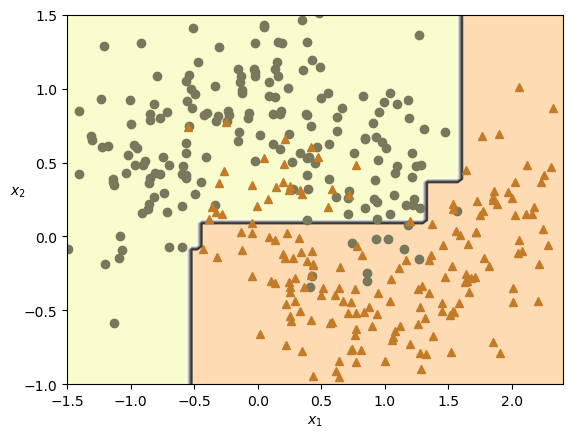

In [57]:
plot_decision_boundary(ada_clf, X_train, y_train)

### Gradient Boosting

**Gradient Boosting** operates in a similar way to _AdaBoost_. It makes sequential corrections to each prediction, but it performs the process in relation to **residual errors**.

Below, we see a demonstration example using `DecisionTreeRegressor`. Initially, a prediction is made:

In [105]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

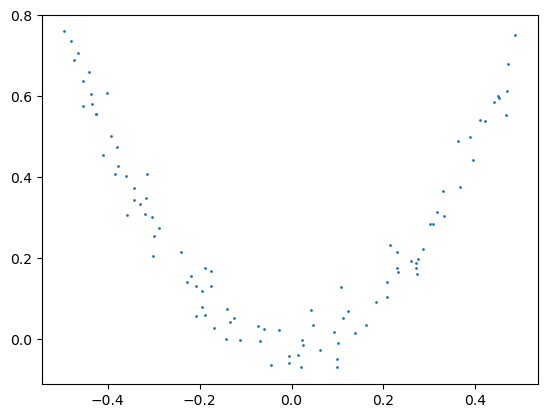

In [112]:
# Plot of function above

plt.scatter(X.squeeze(), y.squeeze(), s=1)
#plt.scatter(X, y, s=1)
plt.show()

First prediction made on the training set:

In [ ]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

After that, the next prediction is made on the residual error of the first prediction, that is, $Residual_{1} = y - h_{1}(x_{1})$, where $h_{1}(x_{1})$ is the prediction made by the first regressor and $h_{2}(x_{1})$ is the prediction made by the second predictor, that would be $h(x_{1}) = h_{1}(x_{1}) + h_{2}(x_{1})$:

In [62]:
y2 = y - tree_reg1.predict(X) # Residual errors made by first predictor
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

Then, the same process is done for the third prediction, where $h(x_{1}) = h_{1}(x_{1}) + h_{2}(x_{1})$ is the prediction, and the residual used is  $Residual_{2} = y - h_{1}(x_{1}) - h_{2}(x_{1})$:

In [64]:
y3 = y2 - tree_reg2.predict(X) # Residual errors made by second predictor
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Here we can see the results for three values. The prediction can be made by the sum of each value from each prediction:

In [103]:
X_new = np.array([[-0.4], [0.], [0.5]])

for tree in (tree_reg1, tree_reg2, tree_reg3):
    prediction_test = tree.predict(X_new)
    print(prediction_test)


[0.48779682 0.12356613 0.52856846]
[-4.31753398e-17 -9.03979359e-02  3.99129745e-02]
[0.00704347 0.00704347 0.18178637]


In [114]:
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

Below, is possible to see the graphs made from either the **Residue and Tree Predictions** on the left, and the **Ensambles Predictions** on the right.

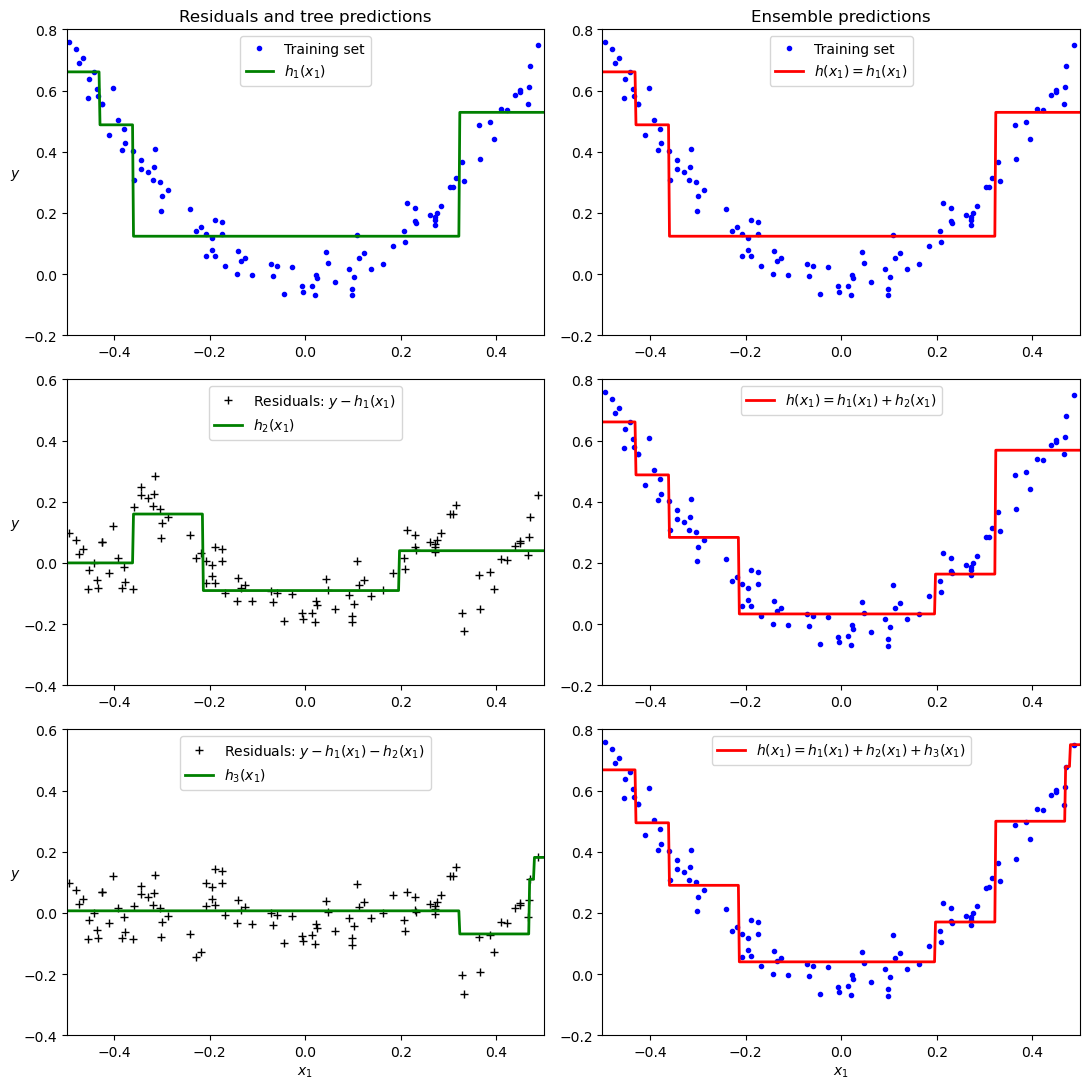

In [143]:
def plot_predictions(regressors, X, y, axes, style, label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)


plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-", label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-", label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-", label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-", label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

It is possible to observe both the use of `GradientBoostingRegression` and the influence of its hyperparameters below. In particular, two hyperparameters:

- `n_estimators`, which indicate how many estimators will be used
- `n_iter_no_change`, which indicates the condition to stop after how many iterations will be made without change

In [126]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [164]:
gbrt_best = GradientBoostingRegressor(max_depth=2, random_state=42, 
                                      learning_rate=0.05, n_estimators=500, n_iter_no_change=10) # lower learning rate, more estimators and limitation
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

This indicate how many iteractions where made until reach the optimal value:

In [166]:
gbrt_best.n_estimators_

92

We can see an example of the regularization technique called **Shrinkage**, where by selecting a small value for the learning rate (as below, 0.05), more estimators will be needed, the prediction will generalize better, but it tends to take longer (hyperparameter `n_iter_no_change` reduces this problem). Below we observe the effect of the hyperparameter `learning_rate`:

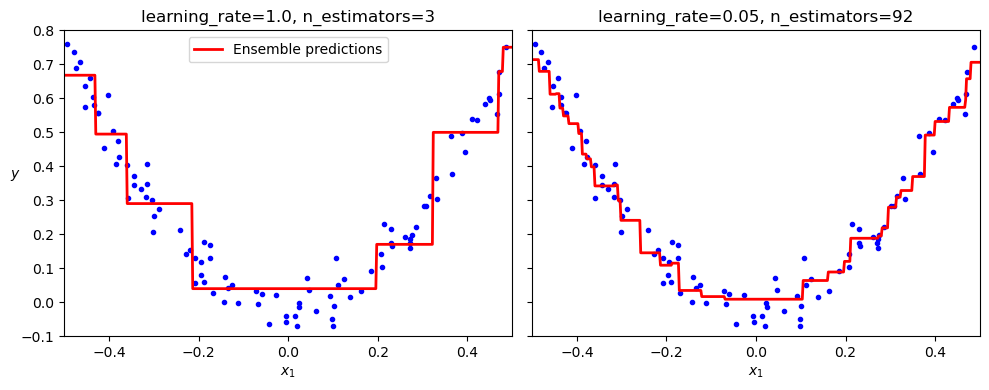

In [132]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-", label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

       
### Histogram-Based Gradient Boosting

## Stackin